<a href="https://colab.research.google.com/github/gunavc/ConceptCraft/blob/master/ConceptCraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# text_processing.py

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')

def process_text(input_text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(input_text)

    # Extract key concepts
    words = nltk.word_tokenize(input_text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

    # Get the most common words as key concepts
    fdist = FreqDist(filtered_words)
    key_concepts = [word for word, _ in fdist.most_common(5)]

    return {
        'sentences': sentences,
        'key_concepts': key_concepts
    }

def generate_prompts(processed_text):
    prompts = []
    for concept in processed_text['key_concepts']:
        prompt = f"Educational illustration of {concept}"
        prompts.append(prompt)
    return prompts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install transformers accelerate safetensors diffusers pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# image_generation.py

import torch
from diffusers import StableDiffusionPipeline

def generate_images(prompts, num_inference_steps=50, guidance_scale=7.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()

    generated_images = []
    for prompt in prompts:
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            image = pipe(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            ).images[0]
        generated_images.append(image)

    return generated_images


def optimize_for_ryzen():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

    # Check if we're running on an AMD GPU
    if torch.cuda.is_available() and 'AMD' in torch.cuda.get_device_name(0):
        # For ROCm (Ryzen) specific optimizations:
        if hasattr(torch.backends.cuda, 'preferred_linalg_library'):
            try:
                torch.backends.cuda.preferred_linalg_library('rocblas')
            except RuntimeError:
                print("ROCm-specific optimizations not available. Using default settings.")

    else:
        print("Not running on AMD GPU. Using default CUDA optimizations.")

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import json
from IPython.display import display

def add_interactivity(images, processed_text):
    interactive_content = []

    for i, (image, sentence) in enumerate(zip(images, processed_text['sentences'])):
        # Add text to image
        img_with_text = add_text_to_image(image, sentence)

        # Define clickable regions
        clickable_regions = [
            {
                'top': 100,
                'bottom': 200,
                'left': 100,
                'right': 200,
                'action': 'show_info',
                'content': f"More info about {processed_text['key_concepts'][i] if i < len(processed_text['key_concepts']) else 'concept'}"
            },
            {
                'top': 300,
                'bottom': 400,
                'left': 300,
                'right': 400,
                'action': 'quiz',
                'content': f"Quiz question about {processed_text['key_concepts'][i] if i < len(processed_text['key_concepts']) else 'concept'}"
            }
        ]

        # Display the image
        display(img_with_text)

        # Create JSON metadata for interactivity
        metadata = {
            'image_index': i,
            'clickable_regions': clickable_regions
        }

        interactive_content.append(metadata)

    # Save the interactive content metadata
    with open('interactive_content.json', 'w') as f:
        json.dump(interactive_content, f)

    return images, 'interactive_content.json'

def add_text_to_image(image, text, font_size=36):
    draw = ImageDraw.Draw(image)

    try:
        # Try to use a common font
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
    except IOError:
        try:
            # If DejaVu is not available, try to use the default font
            font = ImageFont.load_default()
        except IOError:
            # If all else fails, use a very basic bitmap font
            font = ImageFont.load_default()
            print("Warning: Using very basic default font. Text may not appear as expected.")

    # Wrap text
    wrapped_text = wrap_text(text, font, image.width - 20)

    # Calculate text height
    line_height = font.getsize('hg')[1]
    text_height = line_height * len(wrapped_text)

    # Position the text at the bottom center of the image
    y_position = image.height - text_height - 10

    # Draw the text
    for line in wrapped_text:
        line_width, _ = draw.textsize(line, font)
        position = ((image.width - line_width) / 2, y_position)
        draw.text(position, line, font=font, fill=(255, 255, 255))
        y_position += line_height

    return image

def wrap_text(text, font, max_width):
    words = text.split()
    wrapped_lines = []
    current_line = []

    for word in words:
        line_width, _ = font.getsize(' '.join(current_line + [word]))
        if line_width <= max_width:
            current_line.append(word)
        else:
            wrapped_lines.append(' '.join(current_line))
            current_line = [word]

    wrapped_lines.append(' '.join(current_line))
    return wrapped_lines

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Interactive content generated successfully!
Processed text: {'sentences': ['man writing a book'], 'key_concepts': ['man', 'writing', 'book']}


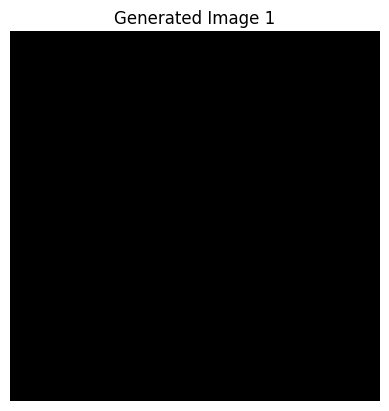

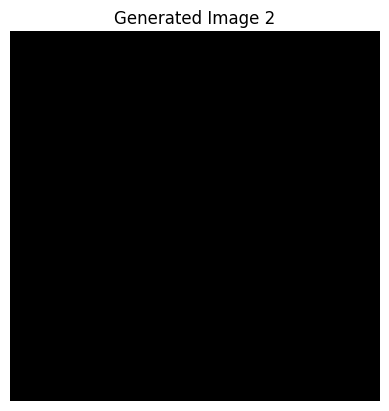

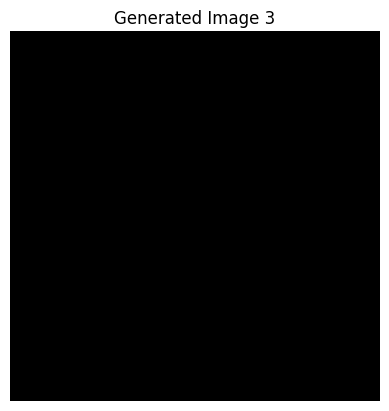

In [ ]:
import torch

def educational_text_to_interactive_content(input_text):
    # Process the input text
    processed_text = process_text(input_text)

    # Generate prompts for image creation
    prompts = generate_prompts(processed_text)

    # Generate images using stable diffusion
    images = generate_images(prompts)

    # Add interactivity to the images and display them
    interactive_images, json_file = add_interactivity(images, processed_text)

    return interactive_images, json_file

if __name__ == "__main__":
    # Example usage
    input_text = "man writing a book"

    # Optimize for Ryzen AI
    optimize_for_ryzen()

    # Generate the interactive content
    images, json_file = educational_text_to_interactive_content(input_text)
    print(f"Interactive content generated successfully! JSON file: {json_file}")
